# World Population
The Wikipedia article on world population contains tables with estimates of world population from prehistory to the present, and projections for the future (<https://modsimpy.com/worldpop>).

The following cell downloads a copy of https://en.wikipedia.org/wiki/World_population_estimates

### System Requirements

In [10]:
try:
    import pint
except ImportError:
    !pip install pint

In [13]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('modsim/modsim.py')

In [14]:
%matplotlib inline

In [15]:
# import functions from modsim

from modsim import *

In [16]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/data/World_population_estimates.html')

### Simulation Preprocess

In [17]:
from pandas import read_html

In [18]:
filename = 'World_population_estimates.html'
tables = read_html(filename,
                   header=0,
                   index_col=0,
                   decimal='M')

In [49]:
table2 = tables[2]

In [50]:
table2.columns = ['census', 'prb', 'un', 'maddison',
                  'hyde', 'tanton', 'biraben', 'mj',
                  'thomlinson', 'durand', 'clark']

In [52]:
census = table2.census / 1e9
un = table2.un / 1e9

#### Variables

In [53]:
total_growth = census[2016] - census[1950]
t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0
p_0 = census[t_0]
annual_growth = total_growth / elapsed_time

##Simulation

In [54]:
system = System(t_0=t_0,
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

In [55]:
show(system)

,value
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


### Constant Growth Model

In [56]:
def run_simulation1(system):
    results = TimeSeries()
    results[system.t_0] = system.p_0

    for t in range(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth

    return results

In [57]:
from matplotlib.pyplot import plot

def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.

    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')

    decorate(xlabel='Year',
             ylabel='World population (billion)',
             title=title)

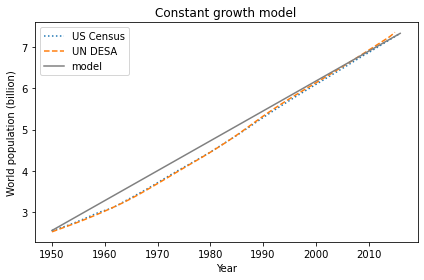

In [58]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

### Proportional Growth Model

In [60]:
system.death_rate = 0.01
system.birth_rate = 0.027

In [61]:
def run_simulation2(system):
    results = TimeSeries()
    results[system.t_0] = system.p_0

    for t in range(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths

    return results

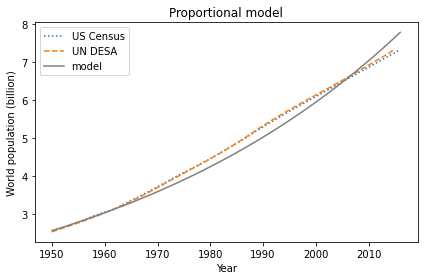

In [62]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')

The proportional model fits the data well from 1950 to 1965, but not so well after that. Overall, the quality of fit is not as good as the constant growth model, which is surprising, because it seems like the proportional model is more realistic.

## Growth Function

In [63]:
def growth_func1(t, pop, system):
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return births - deaths

In [64]:
def run_simulation(system, growth_func1):
    results = TimeSeries()
    results[system.t_0] = system.p_0

    for t in linrange(system.t_0, system.t_end):
        results[t+1] = growth_func1(results[t], t, system)

    return results

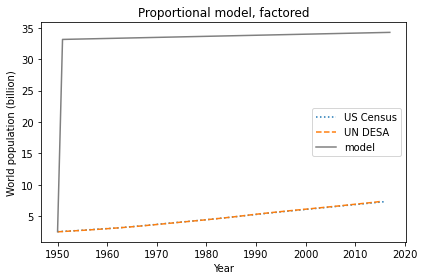

In [65]:
results = run_simulation(system, growth_func1)
plot_results(census, un, results, 'Proportional model, factored')

### Growth Population
### Exercise 1

 Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

growth_func =  that takes `t`, `pop`, and `system` as parameters.
`system`,
        'alpha1` = the growth rate before 1980
        `alpha2` = and the growth rate after 1980,
        `t` to determine which growth rate to use.



In [83]:
# alpha1
t_0 = census.index[0]
t_79 = census.index[27]
elapsed_time1 = t_79 -t_0

p_0 = census[t_0]
p_79 = census[1979]
total_growth1 = p_79 - p_0

alpha1 = total_growth1 / elapsed_time1
print(alpha1)

0.06745871437037038


In [93]:
# alpha2
t_80 = census.index[28]
t_end = census.index[-1]
elapsed_time2 = t_end -t_80

p_80 = census[1980]
p_end = census[t_end]
total_growth2 = p_end - p_0

alpha2 = total_growth2 / elapsed_time2
print(alpha2)

0.12548336986842104


In [95]:
system = System(t_0=t_0,
                t_end=t_end,
                p_0=p_0,
                alpha1 = alpha1,
                alpha2 = alpha2)

In [96]:
def growth_func3(t, pop, system):
    if t <= 1979:
        growth1 = system.alpha1 * pop * 0.0674
        #print(pop + growth1)
        return pop + growth1

    else:
        growth2 = system.alpha2 * pop * 0.17891125
        #print(pop + growth2)
        return pop + growth2

In [97]:
def run_simulation1(system, growth_func3):
    """Simulate the system using any update function.

    system: System object
    update_func: function that computes the population next year

    returns: TimeSeries
    """
    results4 = TimeSeries()
    results4[system.t_0] = system.p_0

    for t in linrange(system.t_0, system.t_end):
        results4[t+1] = growth_func3(results4[t], t, system)

    return results4

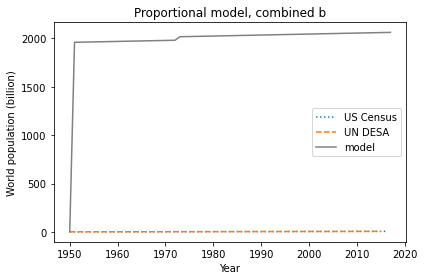

In [98]:
results4 = run_simulation1(system, growth_func3)
plot_results(census, un, results4, 'Proportional model, combined b')

# Pure Python

<AxesSubplot:title={'center':'Census & Forecasts'}, xlabel='Year', ylabel='World Pop Billions'>

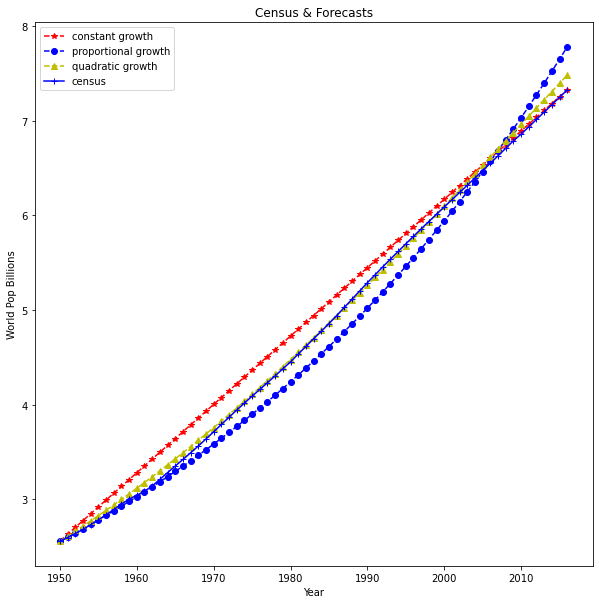

In [13]:
def run_sim(x, birth_rate, death_rate, alpha, beta):
    results1, results2, results3, x = [], [], [], np.asarray(x)
    annual_growth=(x[-1]-x[0])/(len(x)-1)
    results1.append(x[0])
    results2.append(x[0])
    results3.append(x[0])
    for t in np.arange(1,len(x)):
        results1.append(results1[t-1] + annual_growth)
        results2.append(results2[t-1]+(birth_rate-death_rate)* results2[t-1])
        results3.append(results3[t-1]+ alpha*results3[t-1] + beta*results3[t-1]**2)
    x=pd.Series(x, index=census.index, name='census')
    results1=pd.Series(results1, index=census.index, name='constant growth')
    results2=pd.Series(results2, index=census.index, name='proportional growth')
    results3=pd.Series(results3, index=census.index, name='quadratic growth')
    df=pd.concat([results1, results2, results3, x],axis=1)
    return df

a=run_sim(census, .027, .01,.025,-.0018)
a.plot(ylabel='World Pop Billions', title='Census & Forecasts', style=['r*--','bo--','y^--','b+-'], figsize=(10,10))

